# Fine tuning EfficientNet

#### Import libraries

In [1]:
!pip install torchcam

  Using cached torchcam-0.4.0-py3-none-any.whl.metadata (31 kB)
Using cached torchcam-0.4.0-py3-none-any.whl (46 kB)


In [ ]:
import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import InterpolationMode
from torchvision import transforms, models
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import roc_curve, auc
import seaborn as sns

c:\Python310\python.exe


Set random seeds for reproducibility of results.

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Import and read dataset

In [ ]:
# !!!!Dont run this if you already have the dataset downloaded!!!!
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces


  0%|          | 0.00/3.75G [00:00<?, ?B/s]
  0%|          | 1.00M/3.75G [00:00<31:43, 2.11MB/s]
  0%|          | 3.00M/3.75G [00:00<11:55, 5.62MB/s]
  0%|          | 7.00M/3.75G [00:00<05:08, 13.0MB/s]
  0%|          | 11.0M/3.75G [00:00<03:26, 19.4MB/s]
  0%|          | 15.0M/3.75G [00:00<02:42, 24.7MB/s]
  0%|          | 19.0M/3.75G [00:01<02:27, 27.1MB/s]
  1%|          | 23.0M/3.75G [00:01<02:28, 27.0MB/s]
  1%|          | 29.0M/3.75G [00:01<01:59, 33.4MB/s]
  1%|          | 33.0M/3.75G [00:01<01:56, 34.4MB/s]
  1%|          | 37.0M/3.75G [00:01<01:55, 34.6MB/s]
  1%|          | 41.0M/3.75G [00:01<01:50, 35.9MB/s]
  1%|          | 46.0M/3.75G [00:01<01:42, 38.7MB/s]
  1%|▏         | 51.0M/3.75G [00:02<01:46, 37.4MB/s]
  1%|▏         | 55.0M/3.75G [00:02<01:45, 37.6MB/s]
  2%|▏         | 59.0M/3.75G [00:02<01:48, 36.6MB/s]
  2%|▏         | 64.0M/3.75G [00:02<01:41, 39.2MB/s]
  2%|▏         | 68.0M/3.75G [00:02<02:22, 27.7MB/s]
  2%|▏         | 72.0M/3.75G [00:02<02:10, 30.3MB/s]
 

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other



In [ ]:
# !!!! Dont run this if you already have the dataset downloaded and unzipped!!!!
import zipfile

# Specify the path to your zip file and the destination folder
zip_file_path = "../dataset/140k-real-and-fake-faces.zip"  # Ensure this matches your downloaded file's name
destination_folder = "../dataset/extracted_files"  # The folder where the content will be extracted

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Dataset extracted to {destination_folder}")


In [3]:
dataset_path = "../dataset/extracted_files/"  # Updated path, one folder out, then dataset

In [4]:
train_df = pd.read_csv("../dataset/extracted_files/train.csv", index_col=0)
test_df = pd.read_csv("../dataset/extracted_files/test.csv", index_col=0)
valid_df = pd.read_csv("../dataset/extracted_files/valid.csv", index_col=0)
print('Train Dataset Paths and Labels')
display(train_df.head())
print('Test Dataset Paths and Labels')
display(test_df.head())
print('Validation Dataset Paths and Labels')
display(valid_df.head())

Train Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


Test Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


Validation Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg


Adjust paths in the `path` columns

In [9]:
# Base directory where images are stored
base_img_dir = '../dataset/extracted_files/real_vs_fake/real-vs-fake/'

# Combine the base path with the relative paths from the 'path' column
train_df['image_path'] = train_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
valid_df['image_path'] = valid_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
test_df['image_path'] = test_df['path'].apply(lambda x: os.path.join(base_img_dir, x))

#### Visualize some images

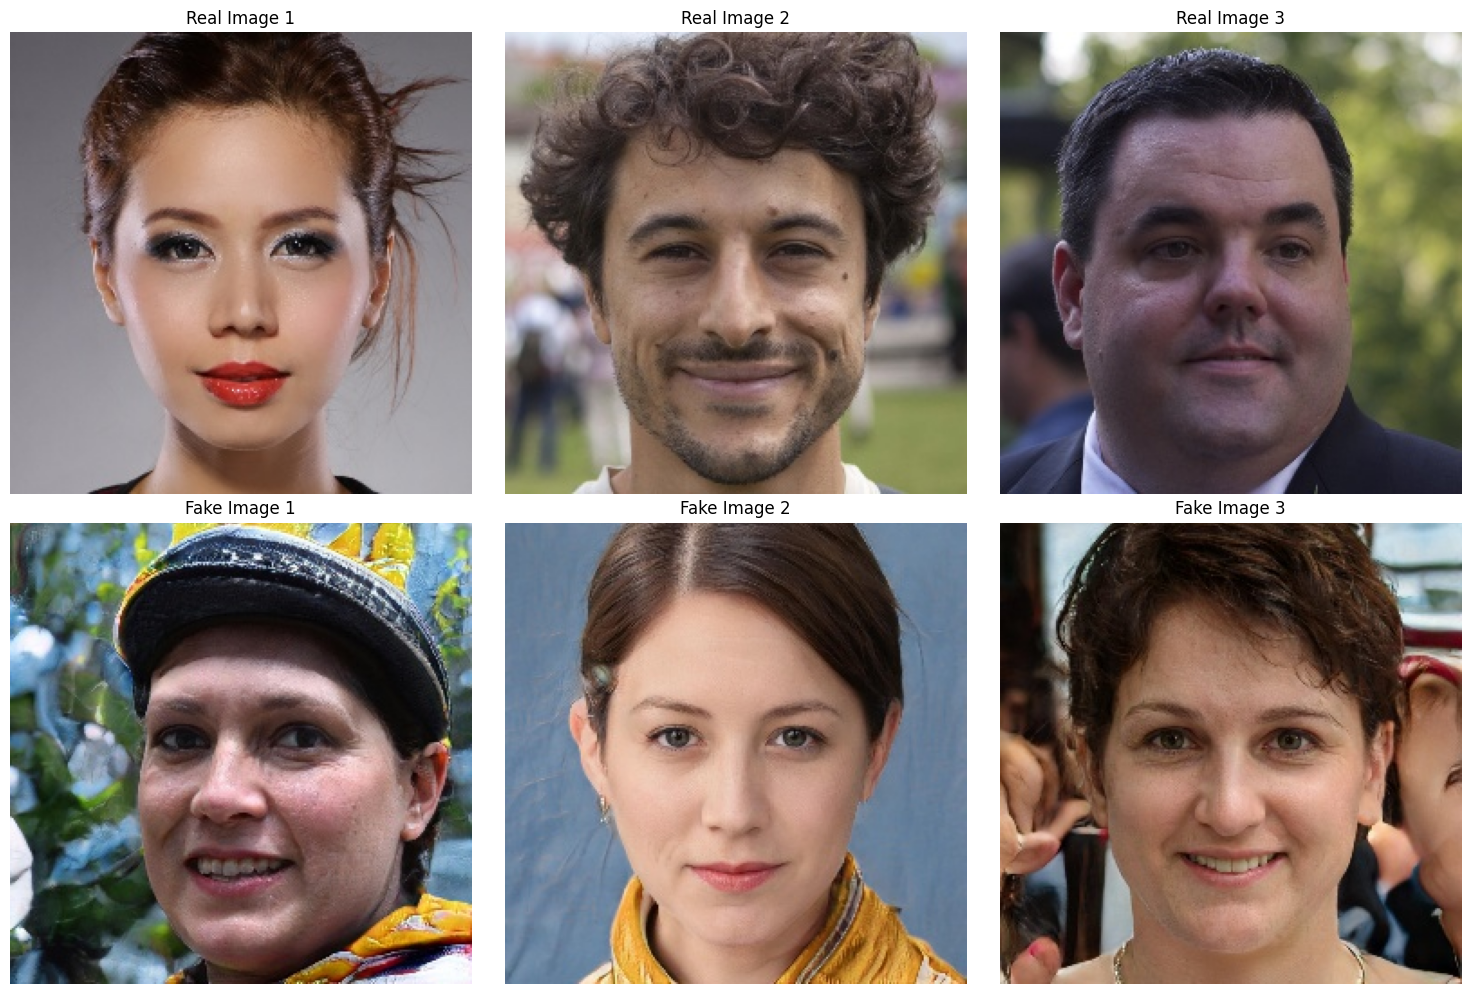

In [ ]:
# Pick 3 real and 3 fake images to show
real_imgs_to_show = random.sample(list(train_df[train_df.label == 1].image_path), 3)
fake_imgs_to_show = random.sample(list(train_df[train_df.label == 0].image_path), 3)

# Open images using PIL
real_images = [Image.open(path) for path in real_imgs_to_show]
fake_images = [Image.open(path) for path in fake_imgs_to_show]

# Display images side by side using Matplotlib
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Add real images in the first row
for ax, img, title in zip(axes[0], real_images, ["Real Image 1", "Real Image 2", "Real Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

# Add fake images in the second row
for ax, img, title in zip(axes[1], fake_images, ["Fake Image 1", "Fake Image 2", "Fake Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### Create FaceDataset class
We create a FaceDataset class that can be passed to a DataLoader, which will take care of batching and shuffling.

In [13]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        '''
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels
            transform (callable, optional): Optional transform to be applied on a sample
        '''
        self.dataframe = dataframe  # Store the dataframe
        self.transform = transform  # Store the transform (if present)

    def __len__(self):
        return len(self.dataframe)  # Return the length of the dataframe

    def __getitem__(self, idx):
        # Get the image path and label from the dataframe
        img_path = self.dataframe.iloc[idx].image_path
        label = int(self.dataframe.iloc[idx].label)  # Label is 0 or 1 (fake or real)

        # Open the image using PIL
        image = Image.open(img_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and label

## Fine-Tuning EfficientNet to the Dataset

#### Load EfficientNet

We will use the pre-trained CNN EfficientNet-B0 and fine-tune it on the 140k-real-and-fake-faces dataset, then compare its accuracy to that of other models. The EfficientNet-B0 model is pre-trained on ImageNet, and we will use its weights available through PyTorch's torchvision library. EfficientNet expects images that are pre-processed with specific transformations, which are detailed in the official PyTorch documentation for EfficientNet models: EfficientNet in PyTorch.

The pre-processing includes resizing the images, cropping them to a standard size, converting them to tensors, and normalizing them using the mean and standard deviation values appropriate for EfficientNet. We apply these transformations to ensure that the input data is compatible with the pre-trained EfficientNet model, allowing it to achieve optimal performance when fine-tuned on our specific dataset.

In [16]:
import torchvision.models as models

# Load pre-trained EfficientNet-B0 (It is possible to change to B1, B2, etc., if desired) 
# B0 is the smallest and fastest, while B7 is the largest and most accurate.
model = models.efficientnet_b0(pretrained=True)

# Define the image transformations for EfficientNet
efficientnet_transform = transforms.Compose([
    transforms.Resize(256),  # Resize images to 256px
    transforms.CenterCrop(224),  # Crop the center 224x224 part
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [17]:
# Create Dataset instances for train, validation, and test sets with EfficientNet transformation
train_dataset = FaceDataset(dataframe=train_df, transform=efficientnet_transform)
valid_dataset = FaceDataset(dataframe=valid_df, transform=efficientnet_transform)
test_dataset = FaceDataset(dataframe=test_df, transform=efficientnet_transform)

# Create DataLoader instances for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the first batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)
print('Batch Shape:')
print(images.shape)  # Should print (batch_size, 3, 224, 224)
print('\nNumber of Labels:')
print(labels.shape)  # Should print (batch_size,)

Batch Shape:
torch.Size([64, 3, 224, 224])

Number of Labels:
torch.Size([64])


#### Fine-Tune the Model

In [ ]:
# Set device to cuda if it is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Move model to the right device
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.Adam(resnet50.parameters(), lr=0.001) # Adam optimizer

In [ ]:
# Initialize lists for accuracies and losses
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
true_labels = []
pred_labels = []
cam_images = []
probs = []

num_epochs = 5

# Initialize Grad-CAM for explainability
cam_extractor = SmoothGradCAMpp(resnet50, target_layer=resnet50.layer4[-1])

In [ ]:
# Iterate over the epochs
for epoch in range(num_epochs):
    # Training Phase
    resnet50.train()  # Set the model to training mode
    train_running_loss = 0.0
    correct, total = 0, 0

    # Iterate over the batches
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        # Set parameter gradients to zero
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimization
        optimizer.step()

        # Increase training loss
        train_running_loss += loss.item()

        # Calculate accuracy
        predicted = torch.max(outputs, 1)[1]  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss for the training epoch
    avg_train_loss = train_running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Calculate training accuracy
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    # Validation Phase
    resnet50.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    for val_inputs, val_labels in valid_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        # Forward pass
        val_outputs = resnet50(val_inputs)

        with torch.no_grad():  # Ensure no gradients for most of the validation loop

            # Compute loss
            val_loss = criterion(val_outputs, val_labels)

            # Increase validation loss
            val_running_loss += val_loss.item()

            # Calculate accuracy
            val_predicted = torch.max(val_outputs, 1)[1]  # Get predicted class
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            # Memorize true and predicted labels for explainability
            true_labels.extend(val_labels.cpu().numpy())
            pred_labels.extend(val_predicted.cpu().numpy())

        # Temporarily enable gradients for CAM generation
        with torch.enable_grad():
            # Get prediction and output for the first image in the batch
            first_prediction = val_predicted[0]
            first_output = val_outputs[0]

            # Generate CAM for the first image
            cams = cam_extractor(first_prediction.item(), first_output)

            # Aggregate the channels into a single-channel heatmap
            cam_single_channel = torch.mean(cams[0], dim=0)  # Average across channels

            # Normalize the heatmap to [0, 1] range for visualization
            cam_normalized = (cam_single_channel - cam_single_channel.min()) / (cam_single_channel.max() - cam_single_channel.min())

            # Convert the single-channel heatmap to a PIL image
            cam_image = to_pil_image(cam_normalized)

            # Save or display the image
            cam_images.append(cam_image)

            # Convert CAM to image and save
            #cam_image = to_pil_image(cams[0])  # Convert CAM to an image
            #cam_images.append(cam_image)  # Save the image

        probs.extend(torch.softmax(val_outputs, dim=1)[:, 1].cpu().detach().numpy())  # Probabilities for class 1

    # Calculate average loss for the validation epoch
    avg_val_loss = val_running_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    # Calculate validation accuracy
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.4f}, "
          f"Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.4f}")

print('Finished Training')

# Save results in a DataFrame
resnet50_results = pd.DataFrame(
    zip(range(1, num_epochs + 1), train_losses, train_accuracies, val_losses, val_accuracies),
    columns=['Epoch', 'Training Losses', 'Training Accuracies', 'Validation Losses', 'Validation Accuracies']
)

100%|██████████| 1563/1563 [06:54<00:00,  3.77it/s]


Epoch 1: Train Loss=0.0204, Train Acc=0.9926, Val Loss=0.0353, Val Acc=0.9885


100%|██████████| 1563/1563 [07:10<00:00,  3.63it/s]


Epoch 2: Train Loss=0.0173, Train Acc=0.9939, Val Loss=0.0522, Val Acc=0.9839


100%|██████████| 1563/1563 [07:09<00:00,  3.64it/s]


Epoch 3: Train Loss=0.0151, Train Acc=0.9948, Val Loss=0.0380, Val Acc=0.9881


100%|██████████| 1563/1563 [06:53<00:00,  3.78it/s]


Epoch 4: Train Loss=0.0136, Train Acc=0.9952, Val Loss=0.0778, Val Acc=0.9792


100%|██████████| 1563/1563 [06:54<00:00,  3.77it/s]


Epoch 5: Train Loss=0.0130, Train Acc=0.9954, Val Loss=0.0268, Val Acc=0.9905
Finished Training


In [ ]:
# Save model weights
model_save_path = '/content/drive/MyDrive/resnet50_weights.pth'
torch.save(resnet50.state_dict(), model_save_path)

In [ ]:
# Display accuracy results
display(resnet50_results)

,Epoch,Training Losses,Training Accuracies,Validation Losses,Validation Accuracies
0,1,0.033304,0.98814,0.035272,0.98850
1,2,0.027453,0.99003,0.052164,0.98395
2,3,0.023034,0.99163,0.037962,0.98810
3,4,0.020411,0.99260,0.077767,0.97920
4,5,0.017295,0.99387,0.026832,0.99045


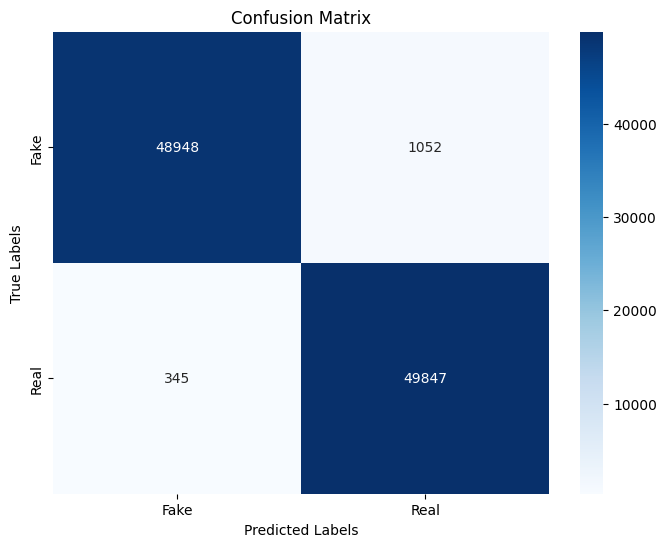

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True,
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
report = classification_report(true_labels, pred_labels, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      0.98      0.99     50000
     Class 1       0.98      0.99      0.99     50192

    accuracy                           0.99    100192
   macro avg       0.99      0.99      0.99    100192
weighted avg       0.99      0.99      0.99    100192



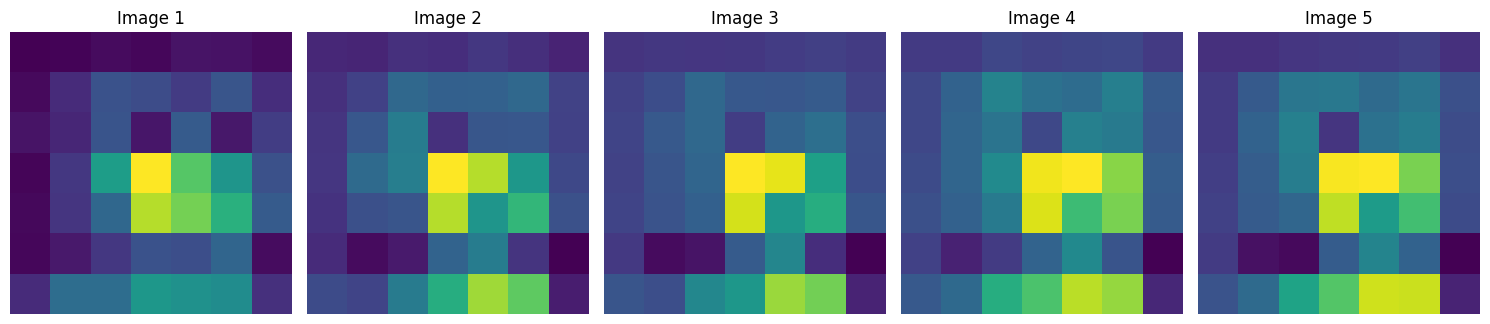

In [ ]:
num_images = 5  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Create a subplot with 1 row and 'num_images' columns

for i in range(num_images):
    # Display the image
    axes[i].imshow(cam_images[2*i])  # Display each Grad-CAM image
    axes[i].axis('off')  # Turn off axis
    axes[i].set_title(f"Image {i+1}")  # Set a title for each image

plt.tight_layout()  # Ensure that images are neatly arranged
plt.show()